In [5]:
import subprocess
import os
import numpy as np
import pandas as pd

import matplotlib

from datetime import datetime

pd.set_option('display.max_rows', 500)

![CRSIP_DM](..\reports\figures\CRISP_DM.png)

# Data Preparation

* focus on understanding the final data structure
* support each step by visual analytics

## John Hopkins github CSV data

In [6]:
git_pull = subprocess.Popen( "git pull" , 
                     cwd = os.path.dirname( '../data/raw/COVID-19/' ), 
                     shell = True, 
                     stdout = subprocess.PIPE, 
                     stderr = subprocess.PIPE )
(out, error) = git_pull.communicate()


print("Error : " + str(error)) 
print("out : " + str(out))

Error : b'From https://github.com/CSSEGISandData/COVID-19\n   89fbfba8..f691d1cd  master              -> origin/master\n * [new branch]        2952-Update-India   -> origin/2952-Update-India\n   da35cc06..3b837781  Update-Peru-July-29 -> origin/Update-Peru-July-29\n   ee45499b..0b08534b  web-data            -> origin/web-data\n'
out : b'Updating 89fbfba8..f691d1cd\nFast-forward\n README.md                                          |   2 +\n .../csse_covid_19_daily_reports/07-28-2020.csv     | 300 ++++++++++----------\n .../csse_covid_19_daily_reports_us/07-28-2020.csv  |   4 +-\n .../csse_covid_19_time_series/Errata.csv           |   7 +\n .../time_series_covid19_confirmed_US.csv           | 302 ++++++++++-----------\n .../time_series_covid19_confirmed_global.csv       |   4 +-\n .../time_series_covid19_deaths_US.csv              |  68 ++---\n .../time_series_covid19_deaths_global.csv          |   4 +-\n .../time_series_covid19_recovered_global.csv       |   2 +-\n 9 files changed, 351 

In [7]:
data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
pd_raw=pd.read_csv(data_path)

In [8]:
pd_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,880,884,884,889,889,897,897,897,907,907
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,705,749,779,812,851,880,916,932,950,1000


In [9]:
time_index = pd_raw.columns[4:]

In [10]:
df_plot = pd.DataFrame({
    'date': time_index
})
df_plot.head()

,date
0,1/22/20
1,1/23/20
2,1/24/20
3,1/25/20
4,1/26/20


In [11]:
type(df_plot['date'][0])

str

In [12]:
country_set = pd_raw['Country/Region'].unique()

In [15]:
country_set

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [16]:
limited_country_list = ['Italy', 'Korea, South', 'Germany', 'Spain', 'US']

In [17]:
for country in limited_country_list:
    df_plot[country] = np.array(pd_raw[pd_raw['Country/Region'] == country].iloc[:, 4::].sum(axis=0))

In [18]:
df_plot.head()

,date,Italy,"Korea, South",Germany,Spain,US
0,1/22/20,0,1,0,0,1
1,1/23/20,0,1,0,0,1
2,1/24/20,0,2,0,0,2
3,1/25/20,0,2,0,0,2
4,1/26/20,0,3,0,0,5


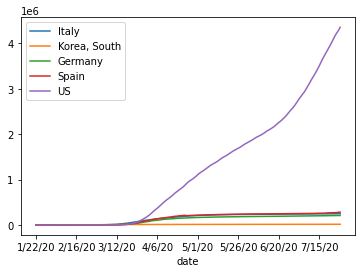

In [19]:
df_plot.set_index('date').plot()

## Data Type Date

In [20]:
time_index= [datetime.strptime(each, '%m/%d/%y') for each in df_plot.date]
time_string_iso = [each.strftime('%Y-%m-%d') for each in time_index]

In [21]:
df_plot['date'] = time_index

In [22]:
df_plot.head()

,date,Italy,"Korea, South",Germany,Spain,US
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,3,0,0,5


In [23]:

df_plot.to_csv('../data/processed/COVID_small_flat_table_July 29_.csv', sep = ';')

  ##  Relational data model

In [28]:
data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
pd_raw=pd.read_csv(data_path)


pd_db = pd_raw.rename(columns= {
    'Country/Region': 'Country',
    'Province/State': 'State'
}).drop(['Lat', 'Long'], axis=1)
pd_db.head()

,State,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,35475,35526,35615,35727,35928,35981,36036,36157,36263,36368
1,NaN,Albania,0,0,0,0,0,0,0,0,...,4090,4171,4290,4358,4466,4570,4637,4763,4880,4997
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,23084,23691,24278,24872,25484,26159,26764,27357,27973,28615
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,880,884,884,889,889,897,897,897,907,907
4,NaN,Angola,0,0,0,0,0,0,0,0,...,705,749,779,812,851,880,916,932,950,1000


In [29]:
pd_db.set_index(['State', 'Country'])

1/22/20  \
State                            Country                                     
NaN                              Afghanistan                             0   
                                 Albania                                 0   
                                 Algeria                                 0   
                                 Andorra                                 0   
                                 Angola                                  0   
                                 Antigua and Barbuda                     0   
                                 Argentina                               0   
                                 Armenia                                 0   
Australian Capital Territory     Australia                               0   
New South Wales                  Australia                               0   
Northern Territory               Australia                               0   
Queensland                       Australia                               0   
South Australia                  Australia                               0   
Tasmania                         Australia                               0   
Victoria                         Australia                               0   
Western Australia                Australia                               0   
NaN                              Austria                                 0   
                                 Azerbaijan                              0   
                                 Bahamas                                 0   
                                 Bahrain                                 0   
                                 Bangladesh                              0   
                                 Barbados                                0   
                                 Belarus                                 0   
                                 Belgium                                 0   
                                 Benin                                   0   
                                 Bhutan                                  0   
                                 Bolivia                                 0   
                                 Bosnia and Herzegovina                  0   
                                 Brazil                                  0   
                                 Brunei                                  0   
                                 Bulgaria                                0   
                                 Burkina Faso                            0   
                                 Cabo Verde                              0   
                                 Cambodia                                0   
                                 Cameroon                                0   
Alberta                          Canada                                  0   
British Columbia                 Canada                                  0   
Grand Princess                   Canada                                  0   
Manitoba                         Canada                                  0   
New Brunswick                    Canada                                  0   
Newfoundland and Labrador        Canada                                  0   
Nova Scotia                      Canada                                  0   
Ontario                          Canada                                  0   
Prince Edward Island             Canada                                  0   
Quebec                           Canada                                  0   
Saskatchewan                     Canada                                  0   
NaN                              Central African Republic                0   
                                 Chad                                    0   
                                 Chile                                   0   
Anhui                            China                                   1   
Beijing    

In [32]:
test_pd = pd_db.set_index(['State', 'Country']).T

In [33]:
test_pd.columns

MultiIndex([(                           nan,           'Afghanistan'),
            (                           nan,               'Albania'),
            (                           nan,               'Algeria'),
            (                           nan,               'Andorra'),
            (                           nan,                'Angola'),
            (                           nan,   'Antigua and Barbuda'),
            (                           nan,             'Argentina'),
            (                           nan,               'Armenia'),
            ('Australian Capital Territory',             'Australia'),
            (             'New South Wales',             'Australia'),
            ...
            (                           nan,                'Malawi'),
            ( 'Falkland Islands (Malvinas)',        'United Kingdom'),
            (   'Saint Pierre and Miquelon',                'France'),
            (                           nan,           'South

In [37]:
test_pd.stack(level =[0,1]).reset_index()

,level_0,State,Country,0
0,1/22/20,NaN,Afghanistan,0.0
1,1/22/20,NaN,Albania,0.0
2,1/22/20,NaN,Algeria,0.0
3,1/22/20,NaN,Andorra,0.0
4,1/22/20,NaN,Angola,0.0
...,...,...,...,...
85423,7/28/20,Zhejiang,West Bank and Gaza,10938.0
85424,7/28/20,Zhejiang,Western Sahara,10.0
85425,7/28/20,Zhejiang,Yemen,1703.0
85426,7/28/20,Zhejiang,Zambia,5002.0


In [43]:
pd_relational_model = pd_db.set_index(['State', 'Country']).T.stack(level =[0,1])

pd_relational_model = pd_relational_model.reset_index().rename(columns ={
    'level_0' : 'date',
    0: 'confirmed'
})

pd_relational_model['date'] = pd.to_datetime(pd_relational_model['date'], format="%m/%d/%y")

In [44]:
pd_relational_model.dtypes

date         datetime64[ns]
State                object
Country              object
confirmed           float64
dtype: object

In [46]:
pd_relational_model.to_csv('../data/processed/COVID_relational_confirmed.csv', sep = ';')